# Лабораторная работа 3. Подбор гиперпараметров. Калибровка. Работа с текстовыми данными. Библиотека Vowpal Wabbit.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 10 баллов. Также в результате выполнения заданий у вас получится решение [задачи конкурса](https://www.kaggle.com/c/competition-3-yandex-shad-spring-2020), которое после небольшой доработки принесёт ещё 5 баллов за пробитие Medium Baseline.
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса.

## Оценивание качества классификации

Перед тем, как приступить к выполнению заданий, рассмотрим метрики классификации, которые нам пригодятся в дальнейшем.

### Accuracy, Precision, Recall

- Accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (Мы не рекомендуем переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- Precision (точность): $$Precision = \frac{TP}{TP + FP}$$
- Recall (полнота): $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

|  | y = 1 | y = 0 |
| --- | --- | --- |
| a(x) = 1 | TP | FP |
| a(x) = 0 | FN | TN |

Обратите внимание, что точность и полнота вычисляются относительно фиксированного класса. В sklearn есть удобная функция [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), позволяющая сразу вычислять эти метрики для всех классов. 

Точность и полнота хороши тем, что могут быть использованы в случае несбалансированных данных, однако сразу же две метрики оптимизировать не удобно.

### Precision-Recall кривая

Зачастую классификатор может возвращать не конкретный класс, а некоторую меру принадлежности заданному классу $b(x)$. Затем значение $b(x)$ сравнивается с фиксированным порогом *t*, и на самом деле классификатор имеет вид $a(x) = [b(x) > t]$. Таким образом, при оценивании качества работы классификатора можно использовать его ответ $b(x)$ и подбирать порог *t* исходя из некоторых условий. Кроме того, выбор порога влияет на качество классификации:
 - чем больше $t$, тем выше точность, но ниже полнота,
 - чем меньше $t$, тем выше полнота, но ниже точность.

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого строят следующий график: переберем все возможные пороги $t$, откладывая по оси OX полноту получившегося классификатора, а по оси OY — точность. Таким образом можно получить хорошую визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Как следствие, можно измерять площади под указанными кривыми — *Precision-Recall AUC* и *AUC-ROC* соответственно.

### LogLoss

В бинарном случае эта метрика записывается как $$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

В отличии от *AUC-ROC*, для этой метрики необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу, а не "степень принадлежности классу 1" в неопределенной шкале. Приведем пример. Вероятностная шкала может быть нужна, если вы хотите оценить количество денег, которые в среднем принесёт пользователь, кликнув на баннер. Для этого необходимо умножить количество денег, которые вы получаете за клик на баннер, на вероятность клика пользователя, которую предсказывает модель.

## Подбор гиперпараметров. Случайный поиск по сетке

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, так как для каждого фиксированного набора гиперпараметров происходит новое обучение алгоритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственным возможным. Рассмотрим более подробно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге алгоритм будет обучен 80 раз, что уже немало. А если, например, рассмотреть случайный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число обучений алгоритма, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют **случайный** поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого выбираются его значения. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимум быстрее. 

Более детально о случайном поиске по сетке можно прочесть по следующим ссылкам:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

В следующих двух заданиях будем использовать [набор данных](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) с информацией о клиентах банка и их платежах.

Загрузите данные из файла *credit_card_clients.tsv* и разбейте на обучающее и тестовое множество в отношении 4 к 1.

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state=42
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
data_initial = pd.read_csv('credit_card_clients.tsv', sep='\t', header=0).set_index('ID')
X_data = data_initial.drop(columns=['default payment next month'])
y_data = data_initial[['default payment next month']]

X_train_initial = X_data
X_train, X_test, y_train_initial, y_test_initial = train_test_split(X_train_initial, y_data, test_size=0.2, random_state=random_state)
y_train = np.array(y_train_initial).ravel()
y_test = np.array(y_test_initial).ravel()

In [3]:
X_train.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                            
21754      80000    2          2         2   24      0      0      0      0   
252        30000    1          2         2   28      0      0      0      0   
22942     180000    2          5         1   44      0      0     -1     -1   
619        60000    1          1         2   25      0      0      0      0   
17091     130000    2          2         2   25      0      0      0      0   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
ID            ...                                                         
21754      0  ...      78321      73731      39643      39457      3503   
252        0  ...      29155      25255      22001          0      5006   
22942     -1  ...        850          0       6881      10340         0   
619        0  ...      38533      39639      39619      39140      2018   
17091      0  ...     114734     117823     120854     123904      4100   

       PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
ID                                                       
21754      5001      2092      1218      1445       878  
252        1244       851       955         0         0  
22942       850         0      6881     10340       182  
619        1900      2000      1500      1900      2000  
17091      4200      5000      5000      5000     10700  

[5 rows x 23 columns]

### Задание

**(2 балла)**

Сравните, описанные выше, подходы подбора гиперпараметров на практике. А именно, посмотрите как ведет себя обычный и случайный поиск по сетке при одинаковом числе операций (бюджете). Попробуйте найти оптимальные гиперпараметры для SVM с линейным ядром. В данном случае будет интересно найти значения у двух гиперпараметров: коэффициент регуляризации *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)), для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000. В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

 - Для обычного поиска по сетке ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)) сделайте 5 запусков поиска гиперпараметров с бюджетом 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайного) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество.
 
Данная часть лабораторной работы может работать значительное время. Поэтому рекомендуем обратить внимание на параметр *n_jobs* поиска по сетке (есть у обоих классов).

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import expon
from scipy.stats import loguniform
import warnings

warnings.simplefilter("ignore")

def param_gen(n):
    return {
        'C': np.logspace(-1, 2, n),
        'max_iter': np.logspace(3, 4, n),
    }

param_distr = {
    'C': loguniform(0.1, 100),
    'max_iter': loguniform(1000, 10000),
}


clf = SVC(kernel='linear')

columns = ['budget', 'grid', 'random', 'best_C', 'best_max_iter']
result = pd.DataFrame([], columns=columns)

for i in range(2, 7):
    print('budget: ', i)
    grid = GridSearchCV(clf, param_gen(i), n_jobs=-1, scoring='roc_auc')
    grid.fit(X_train, y_train)
    
    rand = RandomizedSearchCV(clf, param_distr, n_jobs=-1, scoring='roc_auc', n_iter=i * i)
    rand.fit(X_train, y_train)
    rand_best = rand.best_score_

    row = [i * i, grid.best_score_, rand_best, grid.best_params_['C'], grid.best_params_['max_iter']]
    result = result.append(pd.DataFrame([row], columns=columns))
result = result.set_index('budget')

budget:  2
budget:  3
budget:  4
budget:  5
budget:  6


Построим таблицу качества от размера бюджета

In [20]:
result

grid    random      best_C  best_max_iter
budget                                               
4       0.565647  0.566459  100.000000    1000.000000
9       0.601487  0.592288    3.162278   10000.000000
16      0.594602  0.600038    0.100000    2154.434690
25      0.612089  0.599297   17.782794    5623.413252
36      0.616245  0.619174    6.309573    1584.893192

Изобразим полученные результаты на графике

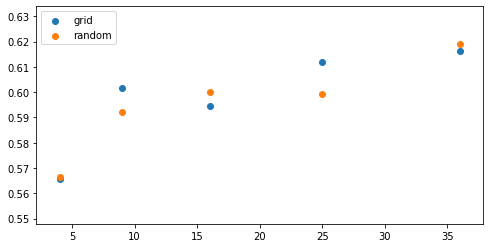

In [21]:
plt.figure(figsize=(8, 4))
plt.scatter(result.index, result['grid'], label='grid')
plt.scatter(result.index, result['random'], label='random')
plt.legend()
plt.show()

**(0.5 балла)**

Сравните полученные графики для разных способов подбора гиперпараметров:
 * Посмотрите на наилучшие гиперпараметры, которые у вас получились. Можно ли сказать, что какой-то из гиперпараметров больше влияет на результат?
 * Можно ли сделать вывод, что случайный поиск проигрывает или же наоборот?
 * Зависит ли ответ на предыдущий вопрос от размера бюджета и удачной инициализации?

Изобразим на графике для разного бюжета при каких оптимальных значениях параметров достигался наилучший результат

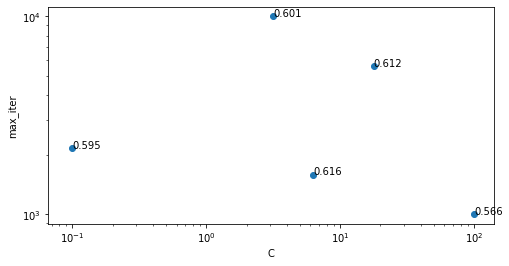

In [18]:
plt.figure(figsize=(8, 4))
plt.scatter(result['best_C'], result['best_max_iter'])

for i, x in result.iterrows():
    plt.annotate(round(x['grid'], 3), (x['best_C'], x['best_max_iter']))
plt.xlabel('C')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('max_iter')
plt.show()

Из графика видно, что нет четкой зависимости, что при увеличении или уменьшении какого-либо из показателей однозначно улучшается качество. Так что оба гиперпараметра в одинаковой степени влияют на результат

Случайный поиск не всегда побеждает простой поиск по сетке, но при увеличении бюджета закономерно, что оба способа сходятся к одной точке.

Так же можно отметить любопытный факт, что для бюджета в 9 достигается лучшее решение чем для бюджета в 16 для поиска по сетке, а для случайного поиска для бюджета 16, лучше чем для бюджета 25. Это говорит о том, что оба способа не дают гарантированного улучшения при увеличении бюджета.

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. Как было сказано выше, в этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

### Задание

**(2 балла)**
 
Рассмотрим SVM из предыдущего пункта. Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки классификатора. Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 
В данном задании необходимо воспользоваться методом *decision_function*, возвращающим значение отступа на объекте. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

Отмасштабируем данные, чтобы корректнее сравнивать калиброванный и не калиброванный классификатор

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_train_norm[X_train_norm.columns] = scaler.transform(X_train_norm[X_train_norm.columns])
X_test_norm[X_test_norm.columns] = scaler.transform(X_test_norm[X_test_norm.columns])

Так как мы отмасштабировали данные, нам нужно снова найти оптимум

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform
import warnings

warnings.simplefilter("ignore")

clf = SVC(kernel='linear')
param_distr = {
    'C': loguniform(1e-3, 1e2),
    'max_iter': loguniform(1e2, 1e4),
}
budget = 40
rand = RandomizedSearchCV(clf, param_distr, n_jobs=-1, scoring='roc_auc', n_iter=budget)
rand.fit(X_train_norm, y_train)
rand.best_score_, rand.best_estimator_

(0.706572192907314,
 SVC(C=0.0036043871391195736, break_ties=False, cache_size=200,
     class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
     gamma='scale', kernel='linear', max_iter=4735.079897560308,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False))

Started: Initial
Initial loss 0.5766343888593258
Started: Isotonic
Isotonic loss 0.45409857022018923
Started: Sigmoid
Sigmoid loss 0.46862712442356835


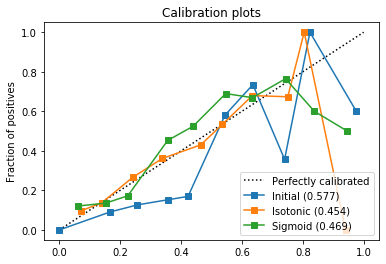

In [10]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.svm import SVC
import warnings

warnings.simplefilter("ignore")

clf_initial = SVC(kernel='linear', C=0.003, max_iter=4735)
clf_isotonic = CalibratedClassifierCV(clf_initial, method='isotonic')
clf_sigmoid = CalibratedClassifierCV(clf_initial, method='sigmoid')

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_initial, 'Initial'),
                  (clf_isotonic, 'Isotonic'),
                  (clf_sigmoid, 'Sigmoid')]:
    
    print('Started:', name)
    clf.fit(X_train_norm, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test_norm)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test_norm)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    clf_score = log_loss(y_test, prob_pos)
    print(name, 'loss', clf_score)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))
    
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots')
plt.show()

**(0.5 балла)**

Посчитайте *logloss* на тестовой выборке для исходного и классификатора после калибровки.

По данным расчетов из предыдущего пункта

`initial logloss = 0.576`

`isotonic logloss = 0.454`

`sigmoid logloss = 0.468`

Для калибровки на отложенной выборке нужно эту выборку создать

In [12]:
X_train2, X_train3, y_train2, y_train3 = train_test_split(X_train_norm, y_train, test_size=0.5, random_state=random_state)

Started: Isotonic
Isotonic loss 0.4581641656632681
Started: Sigmoid
Sigmoid loss 0.4733676352271634


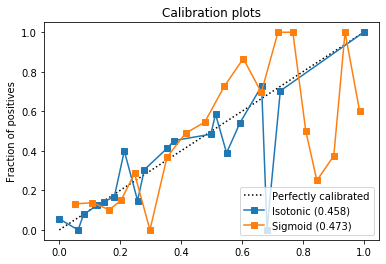

In [14]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import log_loss

clf_initial = SVC(kernel='linear', C=0.003, max_iter=4735)
clf_initial.fit(X_train2, y_train2)
clf_isotonic = CalibratedClassifierCV(clf_initial, cv='prefit', method='isotonic')
clf_sigmoid = CalibratedClassifierCV(clf_initial, cv='prefit', method='sigmoid')

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_isotonic, 'Isotonic'),
                  (clf_sigmoid, 'Sigmoid')]:
    
    print('Started:', name)
    clf.fit(X_train3, y_train3)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test_norm)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test_norm)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=30)

    clf_score = log_loss(y_test, prob_pos)
    print(name, 'loss', clf_score)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))
    
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots')
plt.show()

* Дает ли калибровка прирост качества относительно метрики logloss?
* Какой из способов калибровки в данном случае работает лучше?
* Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат?
* Почему калибровка практически не должна повлиять на AUC-ROC?

- Калибровка дает хороший прирост качества.
- В нашем случае оба способа калибровки практически идентичны по результату
- В целом результат калибровки для нашего случая не сильно зависит от подхода к калибровке. При использовании калибровки на отложенной выборке мы получили немного худшее качество, вероятно из-за того, что исходный классификатор обучался на меньше объеме данных.
- Калибровка - это способ сжатия и растяжения вдоль оси. Поэтому пороги поменяются, их порядок относительно ответа классификатора не изменится